In [1]:
import warnings
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

from mmcv.runner import load_checkpoint
from mmdet.core import get_classes
from mmdet.models import build_detector
from mmdet.apis import inference_detector
from mmcv import Config

/opt/conda/envs/detection/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


# 필요한 기능 정의

In [2]:
def init_detector(config, checkpoint=None, device='cuda:0', cfg_options=None):
    """Initialize a detector from config file.

    Args:
        config (str, :obj:`Path`, or :obj:`mmcv.Config`): Config file path,
            :obj:`Path`, or the config object.
        checkpoint (str, optional): Checkpoint path. If left as None, the model
            will not load any weights.
        cfg_options (dict): Options to override some settings in the used
            config.

    Returns:
        nn.Module: The constructed detector.
    """
    # if isinstance(config, (str, Path)):
    #     config = mmcv.Config.fromfile(config)
    # elif not isinstance(config, mmcv.Config):
    #     raise TypeError('config must be a filename or Config object, '
    #                     f'but got {type(config)}')
    if cfg_options is not None:
        config.merge_from_dict(cfg_options)
    if 'pretrained' in config.model:
        config.model.pretrained = None
    elif 'init_cfg' in config.model.backbone:
        config.model.backbone.init_cfg = None
    config.model.train_cfg = None
    model = build_detector(config.model, test_cfg=config.get('test_cfg'))
    if checkpoint is not None:
        checkpoint = load_checkpoint(model, checkpoint, map_location='cpu')
        if 'CLASSES' in checkpoint.get('meta', {}):
            model.CLASSES = checkpoint['meta']['CLASSES']
        else:
            warnings.simplefilter('once')
            warnings.warn('Class names are not saved in the checkpoint\'s '
                          'meta data, use COCO classes by default.')
            model.CLASSES = get_classes('coco')
    model.cfg = config  # save the config in the model for convenience
    model.to(device)
    model.eval()
    return model

def get_result_gt(df):
    img_result = [[] for _ in range(10)]
    for i in range(len(df)):
        line = df.iloc[i]
        img_result[int(line['label'])].append([line['x_min'], line['y_min'], line['x_max'], line['y_max'], 1.0])
    return img_result

def show_result(img_path, results, class_names, colors, score_thr=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.copy()
    for idx, result in enumerate(results):
        for res in result:
            score = res[4]
            if score_thr < score:
                x_min, y_min, x_max, y_max = map(int, res[:4])
                class_name = class_names[idx]
                color = colors[idx]
                img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 3)
                text_size, _ = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
                text_x = text_size[0]
                text_y = text_size[1]
                img = cv2.rectangle(img, (x_min, y_min), (x_min + text_size[0], y_min + text_y), (0,0,0), -1)
                img = cv2.putText(img, class_name, (x_min, y_min + text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    return img

# Ground Truth bbox를 위해 dataset 불러오기

In [3]:
from pycocotools.coco import COCO
import pandas as pd

# Dataset
class Dataset:
    def __init__(self, data_dir="../../../dataset", json_file="train.json"):
        """
        annotation: annotation 파일 위치
        data_dir: data가 존재하는 폴더 경로
        category_id: ["General trash", "Paper", "Paper pack", "Metal", "Glass",
                        "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
        """

        super().__init__()
        self.data_dir = data_dir
        self.annotation = os.path.join(self.data_dir, json_file)

        info = []
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(self.annotation)
        for image_id in self.coco.getImgIds():
            image_info = self.coco.loadImgs(image_id)[0]
            annotation_id = self.coco.getAnnIds(imgIds=image_info["id"])
            annotation_info_list = self.coco.loadAnns(annotation_id)

            file_name = os.path.join(self.data_dir, image_info["file_name"])

            # [x_min, x_max, y_min, y_max]
            for annotation in annotation_info_list:
                info.append(
                    [
                        image_id,
                        file_name,
                        int(annotation["category_id"]),
                        float(annotation["bbox"][0]),
                        float(annotation["bbox"][0]) + float(annotation["bbox"][2]),
                        float(annotation["bbox"][1]),
                        (float(annotation["bbox"][1]) + float(annotation["bbox"][3])),
                        float(annotation["bbox"][2]),
                        float(annotation["bbox"][3]),
                        float(annotation["area"]),
                    ]
                )

        self.df = pd.DataFrame(
            info,
            columns=[
                "img_id",
                "img_path",
                "label",
                "x_min",
                "x_max",
                "y_min",
                "y_max",
                "width",
                "height",
                "area",
            ],
        )

        self.df["center_x"] = (self.df["x_max"] + self.df["x_min"]) / 2
        self.df["center_y"] = (self.df["y_max"] + self.df["y_min"]) / 2
        
        
    def grouping_bbox_per_img(self):
        """
        Using Example:
            eda = EDADataset()
            img_df, img_df_idx = eda.grouping_bbox_per_img()
            eda.df.iloc[img_df_idx[1]] -> 하나의 이미지에 있는 bbox의 정보를 나타냄
        Return:
            Return group index (dict type)
        """
        group_df = self.df.groupby("img_id")
        return group_df, group_df.groups

# 필요한 정보들 정의

In [6]:
config_path = './[model]FasterRCNN_V3/FasterRCNN_V3_config.py'
checkpoint_path = './[model]FasterRCNN_V3/checkpoint/latest.pth'

In [10]:
cfg = Config.fromfile(config_path)

data_root = '../../../../../dataset/'

cfg.data.train.dataset.img_prefix = data_root
cfg.data.train.dataset.ann_file = os.path.join(data_root, 'train2_swj.json')
cfg.data.val.img_prefix = data_root
cfg.data.val.ann_file = os.path.join(data_root, 'val2_swj.json')
cfg.data.test.img_prefix = data_root
cfg.data.test.ann_file = os.path.join(data_root, 'val2_swj.json')

In [11]:
model = init_detector(cfg, checkpoint=checkpoint_path)

load checkpoint from local path: ./[model]FasterRCNN_V3/checkpoint/latest.pth


In [12]:
dataset = Dataset(data_dir=data_root, json_file='val2_swj.json')
df = dataset.df
_, img_df_idx = dataset.grouping_bbox_per_img()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# Class와 class에 따른 색깔 정의

In [13]:
class_names = [
    "General trash",
    "Paper",
    "Paper pack",
    "Metal",
    "Glass",
    "Plastic",
    "Styrofoam",
    "Plastic bag",
    "Battery",
    "Clothing",]
colors = [(251, 76, 81),
          (251, 76, 195),
          (158, 76, 251),
          (76, 97, 251),
          (76, 190, 251),
          (76, 251, 217),
          (76, 251, 126),
          (251, 251, 76),
          (251, 195, 76),
          (251, 129, 76)]

# Bounding box 비교하기

/opt/ml/baseline/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


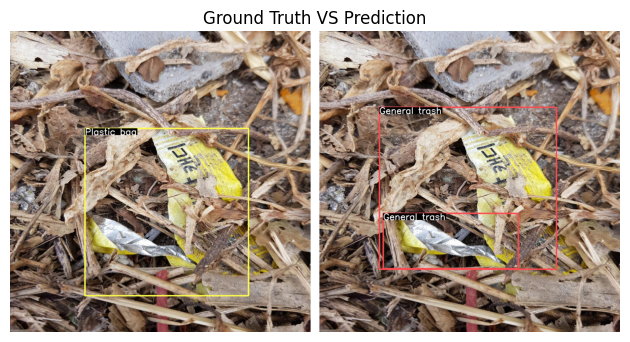

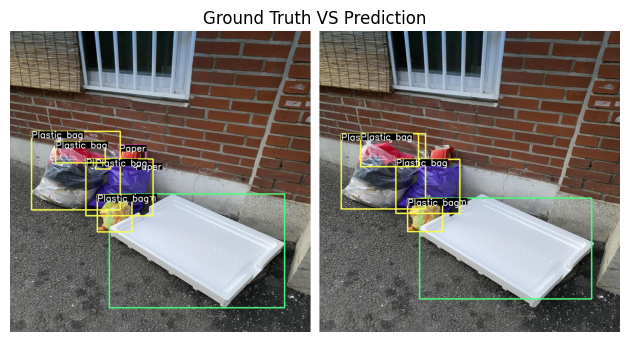

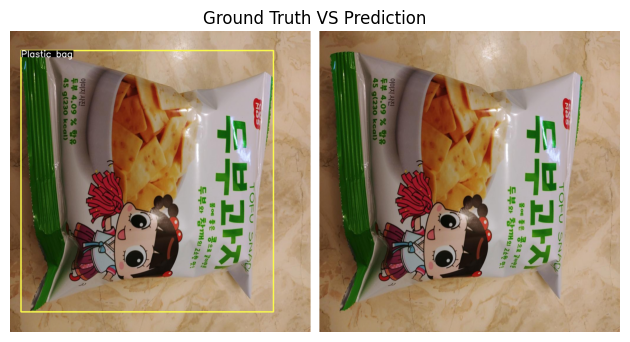

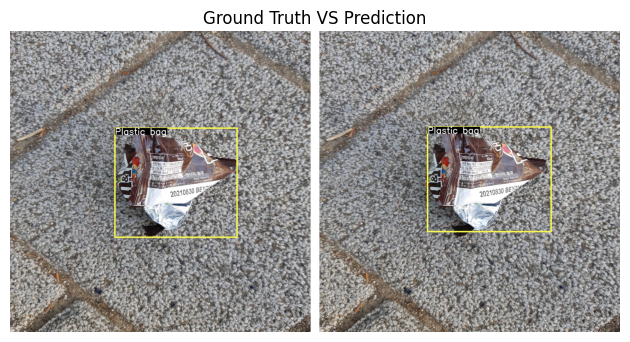

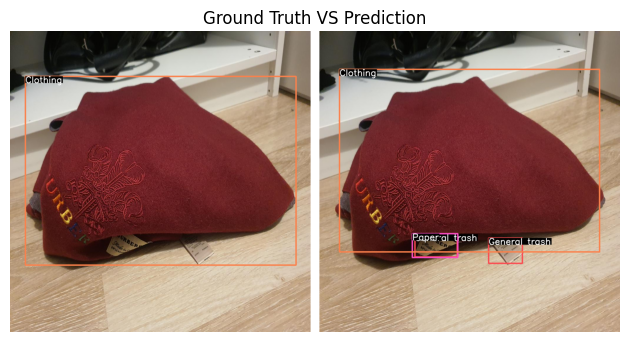

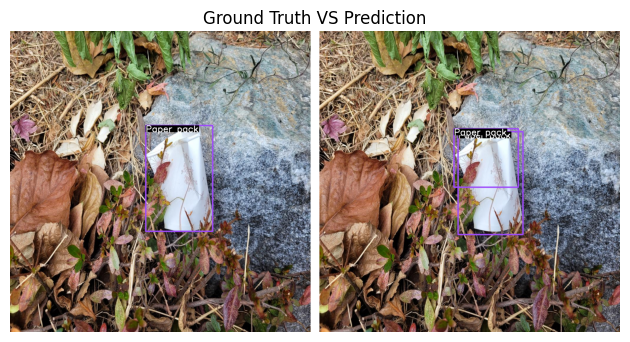

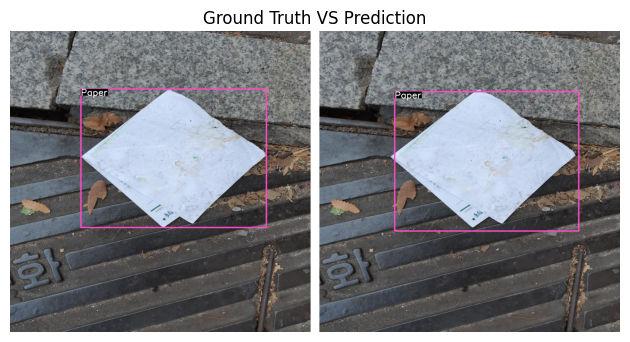

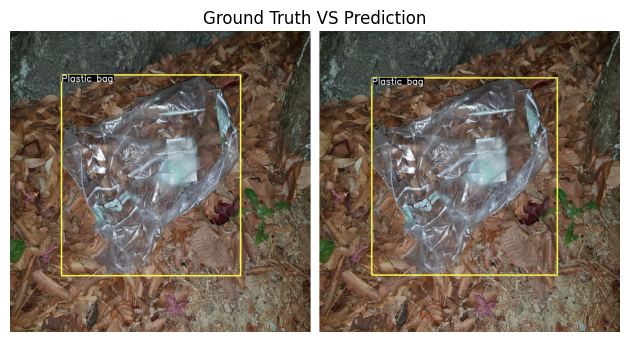

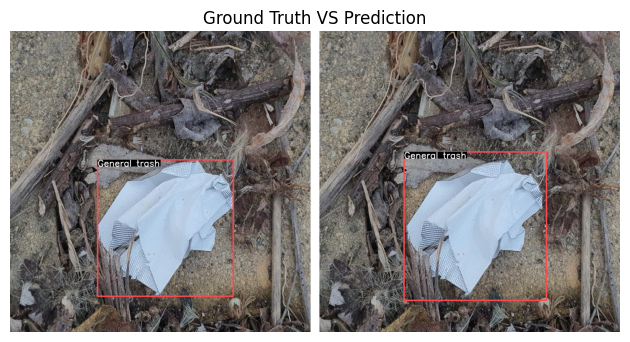

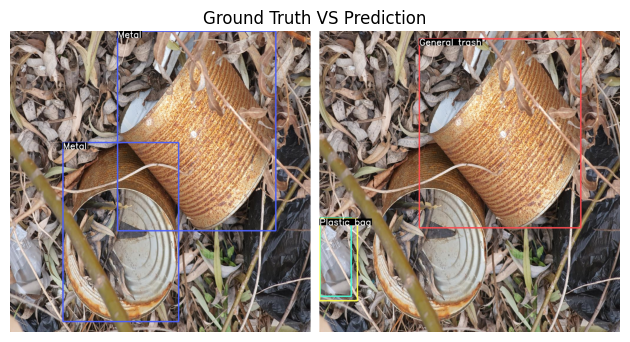

In [14]:
import random
for key in random.sample(list(img_df_idx.keys()), 10):
    img_df = df.iloc[img_df_idx[key]].reset_index()
    path_ = img_df['img_path'].iloc[0].split('/')
    img_path = os.path.join(data_root, path_[-2], path_[-1])
    result_pred = inference_detector(model, img_path)
    result_gt = get_result_gt(img_df)
    img_pred = show_result(img_path, result_pred, class_names, colors, score_thr=0.5)
    img_gt = show_result(img_path, result_gt, class_names, colors, score_thr=0.0)
    line = np.ones((1024,30,3), dtype='uint8')*255
    img = np.concatenate((img_gt, line, img_pred), axis=1)
    plt.imshow(img)
    plt.title('Ground Truth VS Prediction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()